In [54]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import folium
import seaborn as sns
import plotly
import plotly.graph_objects as go

#first model
import problem
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import plotly.express as px

In [55]:
data = pd.read_parquet(Path("data") / "train.parquet")
data["hour"] = data["date"].dt.hour
data["weekday"] = data["date"].dt.weekday
data["monthday"] = data["date"].dt.day
data["week"] = data["date"].dt.isocalendar().week 
data["month"] = data["date"].dt.month

In [56]:
def _merge_external_data(X):
    #file_path = Path(__file__).parent / "external_data.csv"  # uncomment for submission
    file_path = 'external_data.csv' #comment for submission - path to external data
    df_ext = pd.read_csv(file_path, parse_dates=["date"])
    
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge_asof(
        #X.sort_values("date"), df_ext[["date", "rr1","rr3","rr6","rr12","rr24","phenspe1","phenspe2","phenspe3","phenspe4", "t", "ff"]].sort_values("date"), on="date"
        X.sort_values("date"), df_ext.sort_values("date"), on="date"
    )
    # Sort back to the original order
    X["ff_2"] = X["ff"]**2
    X=X.fillna(X.mean())
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X

In [57]:
data=_merge_external_data(data)

/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_60389/696752225.py:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  X=X.fillna(X.mean())
/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_60389/696752225.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X=X.fillna(X.mean())


In [59]:
# basic data
def _encode_dates(X):
    X = X.copy()  # modify a copy of X

    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    #X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    X.loc[:, "weekday_hour"] = X["weekday"].astype(str)+X["hour"].astype(str)

    X = fr_holi(X)

    # Finally we can drop the original columns from the dataframe
    X = X.drop(columns=["date"])
    return X

In [27]:
data_relevant = data[["log_bike_count","hour","weekday","month", "ff", "t", "u"]]
data_relevant.columns = ['log_bikes', 'hour', "weekday","month", "wind", "temperature", "humidity"]

In [28]:
data_relevant_corr = data_relevant.corr()

In [7]:
data_point_sum = data.groupby(["site_name"])["bike_count"].sum().sort_values(
    ascending=False
)
counter_dict=data[["site_name", "latitude", "longitude"]].drop_duplicates("site_name")

data_point_sum = pd.merge(data_point_sum, counter_dict, on ="site_name", how ='inner').drop_duplicates("site_name")


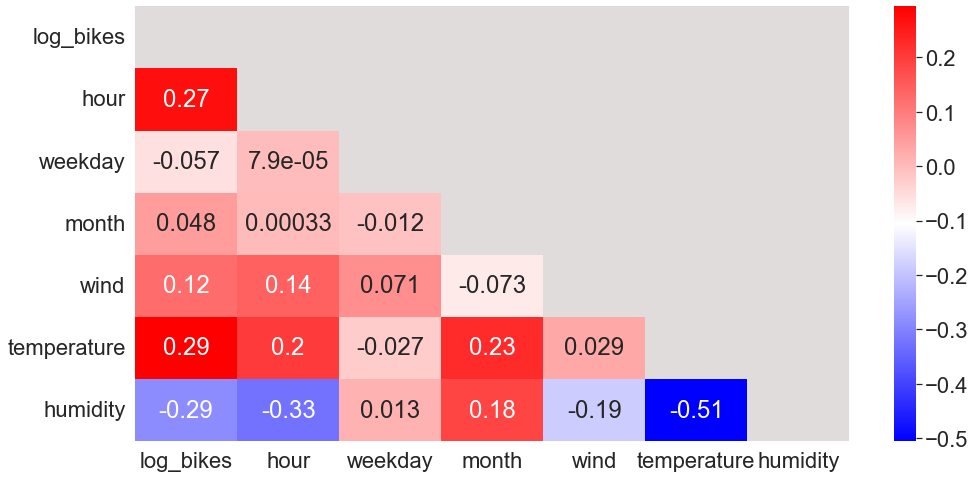

In [50]:
plt.figure(figsize=(16, 8))
# creating mask

mask = np.triu(np.ones_like(data_relevant_corr))
sns.set(font_scale=2, rc={'axes.facecolor':'#e0dcdc', 'figure.facecolor':'#e0dcdc'})
#sns.set(font_scale=2)
#e0dcdc
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(data_relevant_corr, cmap="bwr", annot=True, mask=mask)
 
# displaying heatmap
#plt.axes(color='#e0dcdc')
plt.show()

In [ ]:
data = pd.read_parquet(Path("data") / "train.parquet")
data["hour"] = data["date"].dt.hour
data["weekday"] = data["date"].dt.weekday
data["monthday"] = data["date"].dt.day
data["week"] = data["date"].dt.isocalendar().week 
data["month"] = data["date"].dt.month

step_name = "hour"
fig = go.Figure()
fig.update_layout(mapbox_style="open-street-map")
slider_range=data[step_name].unique()
slider_range.sort()

#adding trace
for step_range in slider_range:
    data_filtered=data[data[step_name] == step_range]


    data_point_sum = data_filtered.groupby(["site_name"])["bike_count"].mean().sort_values(
        ascending=False
    )
    counter_dict=data_filtered[["site_name", "latitude", "longitude"]].drop_duplicates("site_name")

    data_point_sum = pd.merge(data_point_sum, counter_dict, on ="site_name", how ='inner').drop_duplicates("site_name")

    fig.add_trace(go.Scattermapbox(
                        lat=data_point_sum["latitude"],
                        lon=data_point_sum["longitude"],
                        mode='markers',
                        text=data_point_sum["site_name"],
                        opacity=0.4,
                        marker_size=data_point_sum["bike_count"]/5, marker_color='#b50015',
                        hoverinfo='text'))

    
#adding slider    
steps = []
for i in slider_range:
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              #{"title": "Weekday: " + str(i)}
              ],
        label = '{} {}'.format(step_name,i))  # layout attribute
    step["args"][0]["visible"][i-1] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=i,
    #currentvalue={"prefix": "Frequency: "},
    #pad={"t": 0},
    steps=steps
)]


fig.update_geos(fitbounds="locations")
fig.update_mapboxes(
    center={"lat": 48.8566, "lon": 2.3522},
    zoom = 11)
fig.update_layout(
    sliders=sliders, 
    height=700,
    margin={"r":30,"t":20,"l":30,"b":10}
)

fig.show()






In [60]:
#HistGradientBoosting
 
def get_estimator():
    date_encoder = FunctionTransformer(_encode_dates)
    holidays_columns = ["isholiday"]
    time_columns = ["month", "year","weekday", "hour"]
    place_columns = ["site_name"]
    weather_columns = ["u", "t", "ff"]
    phenomenon_columns = ["phenspe2"]
 
    preprocessor = ColumnTransformer([
            ('time', "passthrough", time_columns),
            ('place', OneHotEncoder(categories='auto',handle_unknown='ignore'), place_columns),
            ('weather', "passthrough", weather_columns),
        ], remainder="drop")
 
    regressor = CatBoostRegressor()
 
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        date_encoder, 
        preprocessor, 
        regressor)
 
    return pipe

In [61]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

NameError: name 'y_train' is not defined